In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 输入通道为1，输出通道为16
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)
        )
    def forward(self, x):
        x = self.decoder(x)
        return x 

In [3]:
# 设置
batch_size = 64
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
root = '../datasets'

# 数据预处理，仅包括转换为Tensor
transform = transforms.Compose([
    transforms.ToTensor()  # 将图像转换为Tensor
])

# 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(root, train=True, transform=transform, download=True)

# 创建数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

# 实例化模型
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        en_outputs = encoder(inputs)
        de_outputs = decoder(en_outputs)
        loss = criterion(de_outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

Using cuda device
Files already downloaded and verified
Epoch [1/30], Average Loss: 0.0264
Epoch [2/30], Average Loss: 0.0077
Epoch [3/30], Average Loss: 0.0060
Epoch [4/30], Average Loss: 0.0052
Epoch [5/30], Average Loss: 0.0047
Epoch [6/30], Average Loss: 0.0044
Epoch [7/30], Average Loss: 0.0041
Epoch [8/30], Average Loss: 0.0039
Epoch [9/30], Average Loss: 0.0038
Epoch [10/30], Average Loss: 0.0037
Epoch [11/30], Average Loss: 0.0036
Epoch [12/30], Average Loss: 0.0035
Epoch [13/30], Average Loss: 0.0034
Epoch [14/30], Average Loss: 0.0034
Epoch [15/30], Average Loss: 0.0034
Epoch [16/30], Average Loss: 0.0033
Epoch [17/30], Average Loss: 0.0033
Epoch [18/30], Average Loss: 0.0033
Epoch [19/30], Average Loss: 0.0032
Epoch [20/30], Average Loss: 0.0032
Epoch [21/30], Average Loss: 0.0032
Epoch [22/30], Average Loss: 0.0032
Epoch [23/30], Average Loss: 0.0032
Epoch [24/30], Average Loss: 0.0031
Epoch [25/30], Average Loss: 0.0031
Epoch [26/30], Average Loss: 0.0031
Epoch [27/30], Av

In [4]:
# 创建保存模型的目录（如果它还不存在）
model_dir = '../model/conv_cifar'
os.makedirs(model_dir, exist_ok=True)

# 保存模型状态字典
torch.save(encoder.state_dict(), os.path.join(model_dir, 'encoder.pth'))
torch.save(decoder.state_dict(), os.path.join(model_dir, 'decoder.pth'))

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


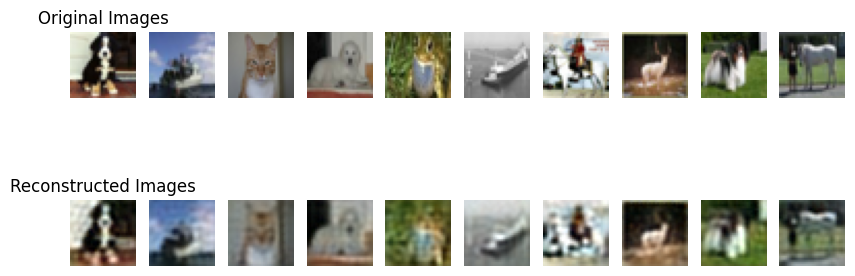

In [5]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化并加载模型
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model_dir = '../model/conv_cifar'

encoder.load_state_dict(torch.load(os.path.join(model_dir, 'encoder.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(model_dir, 'decoder.pth'), map_location=device))

# 将模型设置为评估模式
encoder.eval()
decoder.eval()

# 加载 CIFAR-10 测试数据集
test_dataset = datasets.CIFAR10(root='../datasets', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

# 从数据加载器中获取一批数据
data_iter = iter(test_loader)
images, _ = next(data_iter)

# 将图像移动到设备上
images = images.to(device)

# 使用编码器和解码器
with torch.no_grad():
    encoded_imgs = encoder(images)
    decoded_imgs = decoder(encoded_imgs)

# 将图像移动回CPU，并调整形状以适应 CIFAR-10 的图像尺寸
images = images.cpu()
decoded_imgs = decoded_imgs.view(-1, 3, 32, 32).cpu()

# 绘制原始图像和重建图像
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
for i in range(10):
    # 显示原始图像
    ax = axes[0, i]
    ax.imshow(images[i].view(3, 32, 32).permute(1, 2, 0))
    ax.axis('off')

    # 显示重建图像
    ax = axes[1, i]
    ax.imshow(decoded_imgs[i].permute(1, 2, 0))
    ax.axis('off')

axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('Reconstructed Images')
plt.show()